In [1]:
# imports

import os
import os.path
import cv2
import glob
import h5py
import tqdm
import argparse
import logging
from PIL import Image, ImageOps

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

sns.set_theme()
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

import sys

sys.path.append('../')
import data, utils, models

In [2]:
# EXAMPLE NUMBER
example = 1  # Set 1 for another example

In [3]:
# necessary variable deifnitons

parallel = True
Fast = False
pretrained = True
old = True
load_opt = False

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transform = transforms.Compose([transforms.ToPILImage(mode="RGB")])
to_gray = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1)])

dataset = "DAVIS"
if example == 0:
    video = "giant-slalom"
elif example == 1:
    video = "bus"
patch_size = 128
stride = 64
is_image = False
n_frames = 5
cpf = 3
mid = n_frames // 2
is_real = False

aug = 0

dist = 'G'
mode = 'S'
# change noise_std parameter here to produce results at various noise levels
noise_std = 30
min_noise = 0
max_noise = 100

batch_size = 1
lr = 1e-4

In [4]:
# load model - UDVD

PATH = "../pretrained/blind_video_net.pt"

model, optimizer, args = utils.load_model(PATH, parallel=parallel, pretrained=pretrained, old=old, load_opt=load_opt)
model.to(device)
print(model)

BlindVideoNet(
  (rotate): rotate()
  (denoiser_1): Blind_UNet(
    (enc1): ENC_Conv(
      (conv1): Conv(
        (shift_down): ZeroPad2d((0, 0, 1, 0))
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(9, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (conv2): Conv(
        (shift_down): ZeroPad2d((0, 0, 1, 0))
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (conv3): Conv(
        (shift_down): ZeroPad2d((0, 0, 1, 0))
        (crop): crop()
        (replicate): ReplicationPad2d((1, 1, 1, 1))
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (pool): Pool(
        (shift): shift(
       

In [7]:
# data loader

PATH = os.path.join("../datasets", dataset)

train_loader, test_loader = data.build_dataset("SingleVideo", PATH, batch_size=batch_size, dataset=dataset, video=video,
                                               image_size=patch_size, stride=stride, n_frames=n_frames,
                                               aug=aug, dist=dist, mode=mode, noise_std=noise_std, min_noise=min_noise,
                                               max_noise=max_noise,
                                               sample=True)

In [8]:
# prepare frame

px = 20 * np.arange(0, 6) + 8
py = 20 * np.arange(0, 6) + 8
ps, qs = np.meshgrid(px, py)
ps = ps.reshape(-1)
qs = qs.reshape(-1)

if example == 0:
    # giant-slalom
    num = 109
    x = 425;
    y = 115;
    w = 128;
    h = 128
    x1 = 38;
    y1 = 15;
    w1 = 64;
    h1 = 64
    ps = np.append(ps, 70);
    qs = np.append(qs, 47)
elif example == 1:
    # bus
    num = 25
    x = 481;
    y = 219;
    w = 128;
    h = 128
    x1 = 0;
    y1 = 0;
    w1 = 128;
    h1 = 128
    ps = np.append(ps, 64);
    qs = np.append(qs, 64)

span = 1

sample = test_loader.dataset[num][0].unsqueeze(0)[:, :, y:y + h, x:x + w].to(device)
N, C, H, W = sample.shape

fixed_noises = []
for i in range(span + 5):
    fixed_noises.append(utils.get_noise(sample[:, 0:3, :, :], dist="G", mode='S', noise_std=255))

In [9]:
# compute the jacobian (filters)

grad_mapss = []
pss = [];
qss = [];

model.eval()

for l in range(len(ps)):
    grad_maps = []
    p = ps[l]
    q = qs[l]
    pss.append([ps[l]])
    qss.append([qs[l]])
    for i in range(span):
        sample = test_loader.dataset[num + i][0].unsqueeze(0)[:, :, y:y + h, x:x + w].to(device)

        clean_image = sample[:, (mid * cpf):((mid + 1) * cpf), :, :]
        if not is_real:
            # generate synthetic noise
            noise = (noise_std / 255.0) * torch.cat(fixed_noises[i:i + 5], 1)
            noisy_inputs = noise + sample
            noisy_frame = noisy_inputs[:, (mid * cpf):((mid + 1) * cpf), :, :]
        else:
            # use the sample directly without adding synthetic noise
            noisy_inputs = sample
            noisy_frame = clean_image
        noisy_inputs = noisy_inputs.requires_grad_(True)

        N, C, H, W = sample.shape
        noise_map = (noise_std / 255) * torch.ones(N, 1, H, W).to(device)

        if not Fast:
            output, _ = model(noisy_inputs)

            if not is_real:
                output, mean_image = utils.post_process(output, noisy_frame, model="blind-video-net",
                                                        sigma=noise_std / 255, device=device)
                psnr = utils.psnr(clean_image, output)
        else:
            output = model(noisy_inputs, noise_map)
            psnr = utils.psnr(clean_image, output)

        loss = 100 * output[:, :, q, p].mean()

        model.zero_grad()

        loss.backward()

        grads = noisy_inputs.grad.cpu().detach()

        grad_maps.append(grads)

        img = (np.sum(grads[0, 9:12, :, :].cpu().detach().numpy(), axis=0) / cpf).reshape(H, W)

        ptile = 0.5 * np.max(img)
        w_sum = 0
        p_final = 0
        q_final = 0
        for j in range(h):
            for k in range(w):
                if img[j][k] >= ptile:
                    p_final += k * img[j][k]
                    q_final += j * img[j][k]
                    w_sum += img[j][k]
        p_final /= w_sum
        q_final /= w_sum

        pss[l].append(int(p_final))
        qss[l].append(int(q_final))

        p = int(p_final)
        q = int(q_final)

    grad_mapss.append(grad_maps)

original_ps = np.copy(ps)
original_qs = np.copy(qs)

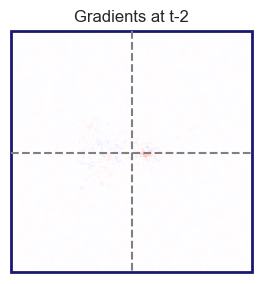

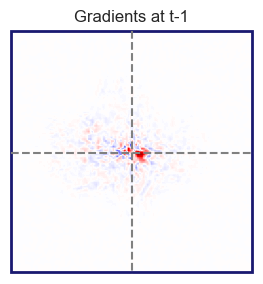

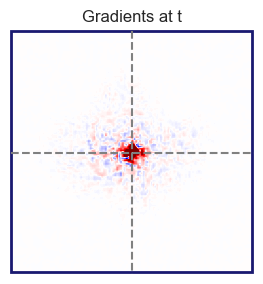

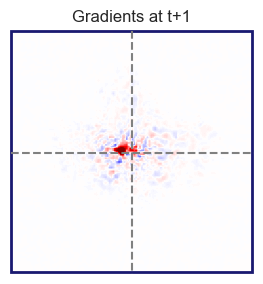

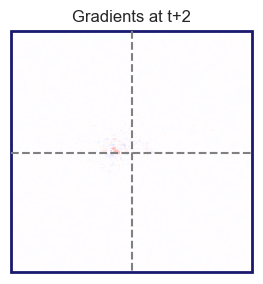

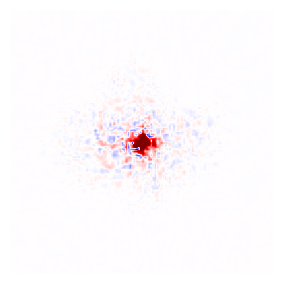

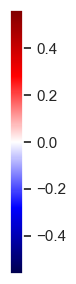

In [10]:
# Gradients - Jacobian (filters)

save = 0
ps = original_ps[36:37]
qs = original_qs[36:37]

alpha = 1
limit = 0
for l in range(len(ps)):
    limit = max(limit, 1 * np.max(np.abs(grad_mapss[l][0].numpy())))

for i in range(5):

    fig, ax = plt.subplots(figsize=(3, 3))

    ax.hlines(h1 / 2, xmin=0, xmax=w1, linestyles='dashed', color='gray')
    ax.vlines(w1 / 2, ymin=0, ymax=h1, linestyles='dashed', color='gray')

    ax.imshow(np.sum(grad_mapss[-1][0][0, i * 3:(i + 1) * 3, y1:y1 + h1, x1:x1 + w1].numpy(), axis=0).reshape(w1, h1),
              cmap="seismic",
              vmin=-limit, vmax=limit)

    rect = patches.Rectangle((0, 0), w1 - 1, h1 - 1, linewidth=2, edgecolor="midnightblue", facecolor='none')
    ax.add_patch(rect)

    if i < 2:
        ax.set_title(f"Gradients at t-{2 - i}")
    elif i == 2:
        ax.set_title("Gradients at t")
    else:
        ax.set_title(f"Gradients at t+{i - 2}")
    ax.axis("off")

    ax.set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                        hspace=0, wspace=0)
    plt.margins(0, 0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.figure(figsize=(3, 3))
img = plt.imshow(np.sum(grad_mapss[-1][0][0, 6:9, y1:y1 + h1, x1:x1 + w1].numpy(), axis=0).reshape(w1, h1),
                 cmap="seismic", vmin=-limit, vmax=limit)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

fig, ax = plt.subplots(figsize=(3, 3))
cbar = plt.colorbar(img, ax=ax)
ax.remove()
plt.tight_layout()

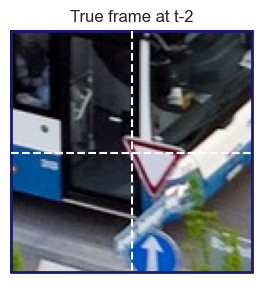

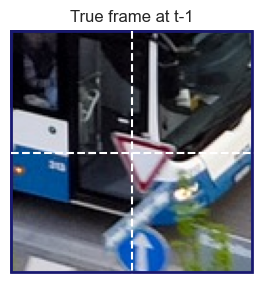

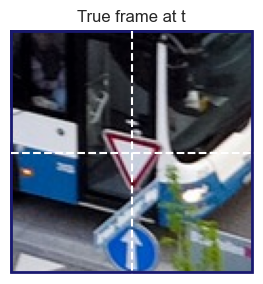

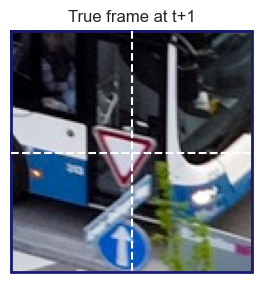

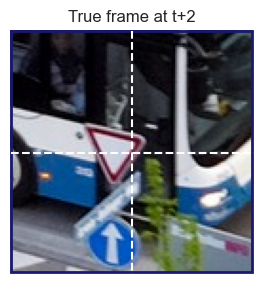

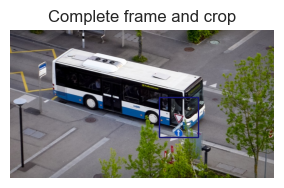

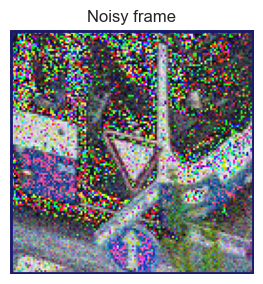

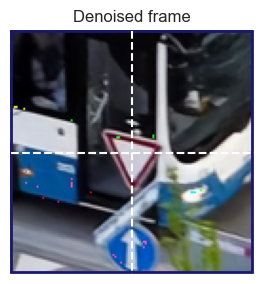

In [11]:
# Images

for i in range(5):
    pclr = 'lime'

    fig, ax = plt.subplots(figsize=(3, 3), frameon=False)
    ax.hlines(h1 / 2, xmin=0, xmax=w1, linestyles='dashed', color='white')
    ax.vlines(w1 / 2, ymin=0, ymax=h1, linestyles='dashed', color='white')
    ax.imshow(transform(test_loader.dataset[num][0][i * 3:(i + 1) * 3, y + y1:y + y1 + h1, x + x1:x + x1 + w1]))

    rect = patches.Rectangle((0, 0), w1 - 1, h1 - 1, linewidth=2, edgecolor="midnightblue", facecolor='none')
    ax.add_patch(rect)

    if i < 2:
        ax.set_title(f"True frame at t-{2 - i}")
    elif i == 2:
        ax.set_title("True frame at t")
    else:
        ax.set_title(f"True frame at t+{i - 2}")
    ax.axis("off")

    ax.set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                        hspace=0, wspace=0)
    plt.margins(0, 0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

fig, ax = plt.subplots(figsize=(3, 3), frameon=False)

img = test_loader.dataset[num][0][6:9, :, :]
# print(img)
# img = cv2.cvtColor(, cv2.COLOR_BGR2RGB)
ax.imshow(transform(img)) # Extract the correct slice

rect = patches.Rectangle((x + x1, y + y1), w1, h1, linewidth=1, edgecolor='midnightblue', facecolor='none')
ax.add_patch(rect)

ax.set_title("Complete frame and crop")
ax.axis("off")

ax.set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0, wspace=0)
plt.margins(0, 0)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

plt.xticks([])
plt.yticks([])
plt.tight_layout()

fig, ax = plt.subplots(figsize=(3, 3), frameon=False)

noisy_img = np.array(transform(test_loader.dataset[num][0][6:9, y + y1:y + y1 + h1, x + x1:x + x1 + w1]
                               + (noise_std / 255) * fixed_noises[2][0, :, y1:y1 + h1, x1:x1 + w1].cpu()))

ax.imshow(transform(noisy_img))
rect = patches.Rectangle((0, 0), w1 - 1, h1 - 1, linewidth=2, edgecolor='midnightblue', facecolor='none')
ax.add_patch(rect)

ax.set_title("Noisy frame")
ax.axis("off")

ax.set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0, wspace=0)
plt.margins(0, 0)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

plt.xticks([])
plt.yticks([])
plt.tight_layout()

fig, ax = plt.subplots(figsize=(3, 3), frameon=False)

ax.hlines(h1 / 2, xmin=0, xmax=w1, linestyles='dashed', color='white')
ax.vlines(w1 / 2, ymin=0, ymax=h1, linestyles='dashed', color='white')

ax.imshow(transform(output[0, :, y1:y1 + h1, x1:x1 + w1].cpu().detach()))

rect = patches.Rectangle((0, 0), w1 - 1, h1 - 1, linewidth=2, edgecolor='midnightblue', facecolor='none')
ax.add_patch(rect)

ax.set_title("Denoised frame")
ax.axis("off")

ax.set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0, wspace=0)
plt.margins(0, 0)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [12]:
# Calulate the arrows for Motion Compensation

ps = original_ps[0:36]
qs = original_qs[0:36]

limit = 0.4
fpss = [];
fqss = [];
npss = [];
nqss = []
for l in range(len(ps)):
    fpss.append([ps[l]])
    npss.append([ps[l]])
    fqss.append([qs[l]])
    nqss.append([qs[l]])

for i in range(span + 1):
    img = np.array(transform(test_loader.dataset[num + i][0][6:9, y:y + h, x:x + w]))
    noisy_img = np.array(transform(
        test_loader.dataset[num + i][0][6:9, y:y + h, x:x + w] + (noise_std / 255) * fixed_noises[2 + i][0, :, :,
                                                                                     :].cpu()))

    img0 = np.array(to_gray(test_loader.dataset[num + i][0][6:9, y:y + h, x:x + w]))
    img1 = np.array(to_gray(test_loader.dataset[num + i][0][9:12, y:y + h, x:x + w]))
    noisy_img0 = np.array(to_gray(
        test_loader.dataset[num + i][0][6:9, y:y + h, x:x + w] + (noise_std / 255) * fixed_noises[2 + i][0, :, :,
                                                                                     :].cpu()))
    noisy_img1 = np.array(to_gray(
        test_loader.dataset[num + i][0][9:12, y:y + h, x:x + w] + (noise_std / 255) * fixed_noises[3 + i][0, :, :,
                                                                                      :].cpu()))

    flow = utils.estimate_invflow(img0, img1, "DeepFlow")
    noisy_flow = utils.estimate_invflow(noisy_img0, noisy_img1, "DeepFlow")
    for l in range(len(ps)):
        p = fpss[l][-1];
        q = fqss[l][-1];
        Np = npss[l][-1];
        Nq = nqss[l][-1]
        fpss[l].append(min(p - int(flow[q][p][0]), w - 1));
        fqss[l].append(min(q - int(flow[q][p][1]), h - 1));
        npss[l].append(min(Np - int(noisy_flow[Nq][Np][0]), w - 1));
        nqss[l].append(min(Nq - int(noisy_flow[Nq][Np][1]), h - 1));

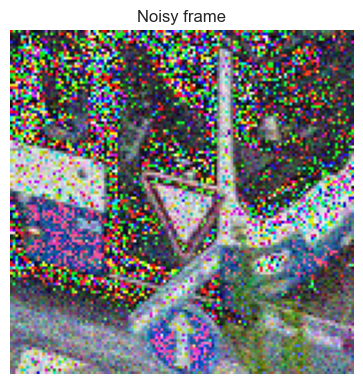

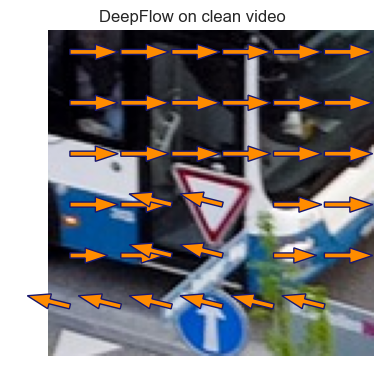

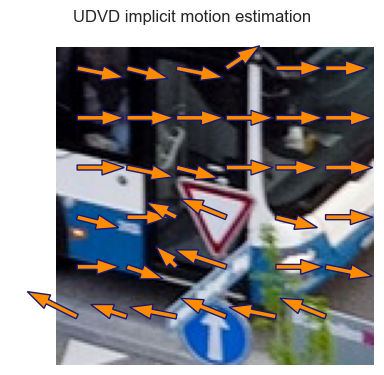

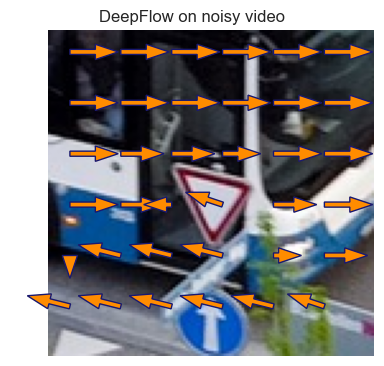

In [13]:
# Motion Compensation

scale = 2
width = 2
head_width = 3 * width
color = "darkorange"

img = np.array(transform(test_loader.dataset[num][0][6:9, y:y + h, x:x + w]))
noisy_img = np.array(transform(
    test_loader.dataset[num][0][6:9, y:y + h, x:x + w] + (noise_std / 255) * fixed_noises[2][0, :, :, :].cpu()))

fig, ax = plt.subplots(figsize=(4, 4), frameon=False)

ax.imshow(noisy_img)
ax.set_title("Noisy frame")
ax.axis("off")

plt.tight_layout()

fig, ax = plt.subplots(figsize=(4, 4), frameon=False)

ax.imshow(img)
ax.set_title("DeepFlow on clean video")
ax.axis("off")

for l in range(len(ps)):
    ax.arrow(fpss[l][0], fqss[l][0],
             scale * (fpss[l][1] - fpss[l][0]),
             scale * (fqss[l][1] - fqss[l][0]), width=width, head_width=head_width,
             length_includes_head=False, facecolor=color, edgecolor='midnightblue')

plt.tight_layout()

fig, ax = plt.subplots(figsize=(4, 4), frameon=False)

ax.imshow(img)
ax.set_title("UDVD implicit motion estimation")
ax.axis("off")

for l in range(len(ps)):
    ax.arrow(pss[l][0], qss[l][0],
             scale * (pss[l][1] - pss[l][0]),
             scale * (qss[l][1] - qss[l][0]), width=width, head_width=head_width,
             length_includes_head=False, facecolor=color, edgecolor='midnightblue')

plt.tight_layout()

fig, ax = plt.subplots(figsize=(4, 4), frameon=False)

ax.imshow(img)
ax.set_title("DeepFlow on noisy video")
ax.axis("off")

for l in range(len(ps)):
    ax.arrow(npss[l][0], nqss[l][0],
             scale * (npss[l][1] - npss[l][0]),
             scale * (nqss[l][1] - nqss[l][0]), width=width, head_width=head_width,
             length_includes_head=False, facecolor=color, edgecolor='midnightblue')

plt.tight_layout()